In [1]:
from kaggle.api.kaggle_api_extended import KaggleApi
import os

# Authenticate Kaggle API
api = KaggleApi()
api.authenticate()

# Correct dataset name
dataset_name = 'ahmedhamada0/brain-tumor-detection'  # Replace with actual dataset name

# Define the download path (use raw string for Windows path)
download_path = r"D:\Deep_Learning\Brain_Tumor_Detection"

# Create the folder if it doesn’t exist
os.makedirs(download_path, exist_ok=True)

# Download and unzip the dataset
api.dataset_download_files(dataset_name, path=download_path, unzip=True)

print(f"Dataset downloaded successfully to: {download_path}")

Dataset URL: https://www.kaggle.com/datasets/ahmedhamada0/brain-tumor-detection
Dataset downloaded successfully to: D:\Deep_Learning\Brain_Tumor_Detection


In [15]:
import cv2
import glob
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical


# Define the dataset
tumor_pos = []
tumor_neg = []

# Load tumor positive images (label 1)
for file in glob.iglob(r'D:\Deep_Learning\Brain_Tumor_Detection\yes\*'):
    img = cv2.imread(file)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
    img = cv2.resize(img, (150, 150))           # Resize to 150x150
    tumor_pos.append((img, 1))                  # Label 1 for tumor

# Load tumor negative images (label 0)
for file in glob.iglob(r'D:\Deep_Learning\Brain_Tumor_Detection\no\*'):
    img = cv2.imread(file)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (150, 150))
    tumor_neg.append((img, 0))                  # Label 0 for no tumor

# Combine data
data = tumor_pos + tumor_neg

# Extract images and labels
x = np.array([i[0] for i in data])  # Images
y = np.array([i[1] for i in data])  # Labels

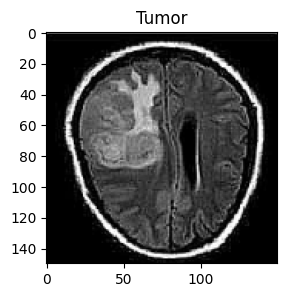

In [3]:
#visualizing the data
def plot_img(i):
    plt.figure(figsize=(3,3))
    plt.imshow(x[i])
    if y[i]==1:
        plt.title('Tumor')
    if y[i]==0:
        plt.title('No_Tumor')

plot_img(42) 

In [4]:
from sklearn.model_selection import train_test_split

#splitting the data into train and test sets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=.20, random_state=42)


In [ ]:
# Normalize the data (0 to 1)
x_train = x_train/255.0
x_test = x_test/255.0

In [13]:
# Convert labels to one-hot encoding for categorical_crossentropy
y_train = to_categorical(y_train, num_classes=2)  # [0] -> [1, 0], [1] -> [0, 1]
y_test = to_categorical(y_test, num_classes=2)

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_11 (Conv2D)          (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 74, 74, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_12 (Conv2D)          (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 36, 36, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_13 (Conv2D)          (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 17, 17, 128)     

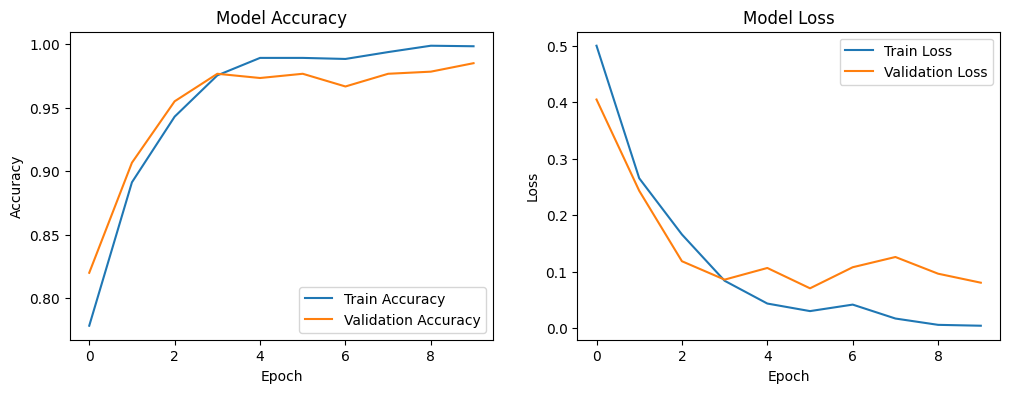

Model saved as 'brain_tumor_cnn_150x150.h5'


In [ ]:

# Define the CNN model
model = models.Sequential([
    # Layer 1: Finds edges (e.g., tissue boundaries)
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
    layers.MaxPooling2D((2, 2)),  # Shrinks to 74x74
    
    # Layer 2: Combines edges into shapes (e.g., tumor textures)
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),  # Shrinks to 36x36
    
    # Layer 3: Sees bigger patterns (e.g., tumor shapes)
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),  # Shrinks to 17x17
    
    # Flatten and classify
    layers.Flatten(),  # Turns 17x17x128 into 36,992 numbers
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.5),  # Prevents overfitting
    layers.Dense(2, activation='softmax')  # Tumor or No Tumor
])

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()  # Shows sizes and parameters

# Define epochs
EPOCHS = 10

# Train the model
history = model.fit(x_train, y_train, epochs=EPOCHS, validation_data=(x_test, y_test), batch_size=32)

# Plot results
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

# Save the model (optional)
model.save('brain_tumor_cnn_150x150.h5')
print("Model saved as 'brain_tumor_cnn_150x150.h5'")

In [ ]:
from tensorflow.keras.models import load_model

# Load the trained model
model = load_model('brain_tumor_cnn_150x150.h5')

# Predict on a new image
def predict_image(image_path):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
    img = img / 255.0  # Normalize
    img = np.expand_dims(img, axis=0)  # Add batch dimension

    prediction = model.predict(img)
    return "Tumor Detected" if np.argmax(prediction) == 1 else "No Tumor"

# Example usage
result = predict_image(r"D:\Deep_Learning\Brain_Tumor_Detection\no\no0.jpg")
print(result) 


1/1 [==============================] - 0s 79ms/step
No Tumor
